In [3]:
!pip install pyvcf

  Stored in directory: /home/adamk/.cache/pip/wheels/81/91/41/3272543c0b9c61da9c525f24ee35bae6fe8f60d4858c66805d
Successfully built pyvcf


In [138]:
!pip install sortedcontainers

In [5]:
!pip install matplotlib

     |████████████████████████████████| 13.1MB 5.8MB/s eta 0:00:01
     |████████████████████████████████| 71kB 21.2MB/s eta 0:00:01
     |████████████████████████████████| 92kB 22.8MB/s eta 0:00:01
     |████████████████████████████████| 17.3MB 21.2MB/s eta 0:00:01


In [63]:
import random
import vcf
import collections
import sortedcontainers
import subprocess
import matplotlib.pyplot as plt
%matplotlib inline
import sortedcontainers
import subprocess
import numpy as np
import time
from intervaltree import Interval, IntervalTree
import os

# Benchmark of Eagle2

SNPs occur throughout human genome, including coding and non-coding regions. In this study we attempt to answer the following question:

Can modern phasing tools, supported with modern, large haplotype/genotype datasets (e.g. 1000 Genome project or the Haplotype Reference Consortium), assign a correct haplotype to SNPs situated in neighbouring genes?

We answer this question by studying two high-quality benchmark genomes, obtained as part of the Genome In A Bottle (GIAB) consortium. These datasets are:

1. the Ashkenazim Jewish trio (done)
2. the Asian trio (TODO).

A probabilistic answer to the question, i.e. "yes they can with probability 85%" would be satisfactory.

# Check the amount of space on the machine. At least 50 GB of space required



In [8]:
!df -h $PWD

Filesystem      Size  Used Avail Use% Mounted on
/dev/sda1       219T  146T   74T  67% /d0


## Download Eagle

In [9]:
!wget https://data.broadinstitute.org/alkesgroup/Eagle/downloads/Eagle_v2.4.1.tar.gz

--2019-07-16 15:14:05--  https://data.broadinstitute.org/alkesgroup/Eagle/downloads/Eagle_v2.4.1.tar.gz
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.92.29
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.92.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225286865 (215M) [application/x-gzip]
Saving to: ‘Eagle_v2.4.1.tar.gz’

Eagle_v2.4.1.tar.gz 100%[===================>] 214.85M  17.0MB/s    in 13s     

2019-07-16 15:14:18 (16.9 MB/s) - ‘Eagle_v2.4.1.tar.gz’ saved [225286865/225286865]



In [10]:
!tar -xvf Eagle_v2.4.1.tar.gz

Eagle_v2.4.1/
Eagle_v2.4.1/eagle
Eagle_v2.4.1/example/
Eagle_v2.4.1/example/target.vcf.gz
Eagle_v2.4.1/example/ref.bcf.csi
Eagle_v2.4.1/example/run_example.sh
Eagle_v2.4.1/example/example_ref.log
Eagle_v2.4.1/example/EUR_test.vcf.gz
Eagle_v2.4.1/example/example.log
Eagle_v2.4.1/example/target.vcf.gz.tbi
Eagle_v2.4.1/example/run_example_ref.sh
Eagle_v2.4.1/example/EUR_test.fam
Eagle_v2.4.1/example/phased.vcf.gz
Eagle_v2.4.1/example/target.phased.vcf.gz
Eagle_v2.4.1/example/run_example_vcf.sh
Eagle_v2.4.1/example/example_vcf.log
Eagle_v2.4.1/example/EUR_test.bim
Eagle_v2.4.1/example/phased.haps.gz
Eagle_v2.4.1/example/ref.bcf
Eagle_v2.4.1/example/phased.sample
Eagle_v2.4.1/example/EUR_test.bed
Eagle_v2.4.1/tables/
Eagle_v2.4.1/tables/genetic_map_hg18_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_hg19_withX.txt.gz
Eagle_v2.4.1/tables/genetic_map_1cMperMb.txt
Eagle_v2.4.1/tables/genetic_map_hg17_withX.txt.gz
Eagle_v2.4.1/src/
Eagle_v2.4.1/sr

In [11]:
!Eagle_v2.4.1/eagle --help

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.4.1              |
                      |   November 18, 2018         |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2018 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

Eagle_v2.4.1/eagle \
    --help 


Options:

  --geneticMapFile arg             HapMap genetic map provided with download: 
                                   tables/genetic_map_hg##.txt.gz
  --outPrefix arg                  prefix for output files
  --numThreads arg (=1)            number of computational threads

Input options for phasing without a reference:
  --bfile arg                      prefix of PLINK .fam, .bim, .bed files
  --bfilegz arg                    prefix of PLINK .fam.gz, .

# Download the GIAB datasets

In [12]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38/HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz

--2019-07-16 15:14:32--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38/HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz
           => ‘HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.11, 2607:f220:41e:250::13
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.11|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG002_NA24385_son/latest/GRCh38 ... done.
==> SIZE HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz ... 129195923
==> PASV ... done.    ==> RETR HG002_GRCh38_GIAB_highconf_CG-Illfb-I

In [13]:
!mv HG002_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC-SOLIDgatkHC_CHROM1-22_v.3.3.2_highconf_triophased.vcf.gz jewish_son.vcf.gz

In [14]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38/HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

--2019-07-16 15:14:38--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38/HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz
           => ‘HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.13, 2607:f220:41e:250::7
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG003_NA24149_father/latest/GRCh38 ... done.
==> SIZE HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz ... 110124812
==> PASV ... done.    ==> RETR HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

In [15]:
!mv HG003_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz jewish_father.vcf.gz

In [16]:
!wget ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38/HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

--2019-07-16 15:14:42--  ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38/HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz
           => ‘HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz’
Resolving ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)... 130.14.250.13, 2607:f220:41e:250::7
Connecting to ftp-trace.ncbi.nlm.nih.gov (ftp-trace.ncbi.nlm.nih.gov)|130.14.250.13|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /giab/ftp/release/AshkenazimTrio/HG004_NA24143_mother/latest/GRCh38 ... done.
==> SIZE HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz ... 112000213
==> PASV ... done.    ==> RETR HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz

In [17]:
!mv HG004_GRCh38_GIAB_highconf_CG-Illfb-IllsentieonHC-Ion-10XsentieonHC_CHROM1-22_v.3.3.2_highconf.vcf.gz jewish_mother.vcf.gz

In [18]:
cp jewish_son.vcf.gz jewish_son_copy.vcf.gz

In [19]:
cp jewish_father.vcf.gz jewish_father_copy.vcf.gz

In [20]:
cp jewish_mother.vcf.gz jewish_mother_copy.vcf.gz

In [21]:
!gunzip jewish_mother_copy.vcf.gz

In [22]:
!gunzip jewish_father_copy.vcf.gz

In [23]:
!gunzip jewish_son_copy.vcf.gz

In [24]:
!ls

Eagle2_benchmark.ipynb	jewish_father.vcf.gz	jewish_son.vcf.gz
Eagle_v2.4.1		jewish_mother_copy.vcf	README.md
Eagle_v2.4.1.tar.gz	jewish_mother.vcf.gz	VCF_HMM_stuff.ipynb
jewish_father_copy.vcf	jewish_son_copy.vcf	venv


# Let's verify if the trio data was used correctly to phase the son genotype

In [32]:
def output_SNP():
    alphabet = ["A", "T", "G", "C"]
    pos = [random.randint(0, len(alphabet) - 1) for i in range(2)]
    return [alphabet[i] for i in pos]

In [33]:
def create_genome(snp_length):
    genome = []
    for i in range(snp_length):
        genome.append(output_SNP())
    return genome

In [34]:
def cross_over(length):
    start = random.randint(0, 1)
    switch_over = random.randint(0, length - 1)
    selection = [start]
    for i in range(length - 1):
        if i < switch_over:
            selection.append(start)
        else:
            selection.append(int(not start))
    return selection

In [35]:
def apply_cross_over(cross_over, genome):
    return [genome[i][j] for i, j in zip(range(len(genome)), cross_over)]

In [36]:
def dephase(genome):
    dephased_genome = []
    for snp in genome:
        new_snp = [i for i in snp]
        random.shuffle(new_snp)
        dephased_genome.append(new_snp)
    return dephased_genome

In [37]:
def reproduce(genome1, genome2):
    co1 = cross_over(len(genome1))
    co2 = cross_over(len(genome2))
    haplo1 = apply_cross_over(co1, genome1)
    haplo2 = apply_cross_over(co2, genome2)
    return [list(k) for k in zip(haplo1, haplo2)]

In [12]:
genome_length = 50

genome1 = create_genome(genome_length)
genome2 = create_genome(genome_length)
offspring = reproduce(genome1, genome2)

dephased_genome1 = dephase(genome1)
dephased_genome2 = dephase(genome2)
dephased_offspring = dephase(offspring)

In [39]:
def phase_offspring(genome1, genome2, offspring):
    possibilities = []
    phased_offspring = []
    for snp_o, snp_g1, snp_g2 in zip(offspring, genome1, genome2):
        snp_o = [i for i in snp_o]
        possibility = [[], []]
        for k in range(0, 2):
            if snp_o[k] in snp_g1:
                possibility[k].append(0)
            if snp_o[k] in snp_g2:
                possibility[k].append(1)
        possibilities.append(possibility)
        # The end statements protect us against a common failure mode which is false homozygosity,
        # i.e. calling a homozygous A/A as opposed to A/T due to low coverage on T
        if   (possibility[0] == [0] and 1 in possibility[1]) or (possibility[1] == [1] and 0 in possibility[0]):
            phased_offspring.append(snp_o + ["|"])
        elif (possibility[1] == [0] and 1 in possibility[0]) or (possibility[0] == [1] and 0 in possibility[1]):
            phased_offspring.append(snp_o[::-1] + ["-|"])
        else:
            phased_offspring.append(snp_o + ["?"])
    return phased_offspring

In [14]:
print(genome1)
print(genome2)
print(offspring)

[['T', 'G'], ['C', 'C'], ['T', 'C'], ['T', 'G'], ['G', 'G'], ['T', 'T'], ['G', 'G'], ['A', 'G'], ['G', 'T'], ['T', 'C'], ['G', 'A'], ['G', 'C'], ['G', 'A'], ['A', 'A'], ['G', 'C'], ['C', 'C'], ['T', 'T'], ['T', 'C'], ['C', 'C'], ['A', 'T'], ['T', 'C'], ['T', 'G'], ['G', 'C'], ['A', 'G'], ['C', 'T'], ['G', 'A'], ['T', 'G'], ['T', 'G'], ['G', 'G'], ['A', 'C'], ['A', 'G'], ['G', 'T'], ['T', 'A'], ['C', 'A'], ['C', 'G'], ['A', 'A'], ['G', 'A'], ['C', 'T'], ['T', 'C'], ['A', 'C'], ['C', 'C'], ['T', 'A'], ['T', 'G'], ['A', 'T'], ['T', 'A'], ['G', 'T'], ['A', 'G'], ['T', 'A'], ['A', 'C'], ['G', 'A']]
[['C', 'T'], ['A', 'A'], ['G', 'T'], ['T', 'T'], ['T', 'G'], ['T', 'C'], ['T', 'A'], ['G', 'A'], ['C', 'A'], ['A', 'T'], ['T', 'G'], ['G', 'C'], ['A', 'T'], ['T', 'T'], ['A', 'C'], ['T', 'G'], ['T', 'T'], ['A', 'T'], ['A', 'G'], ['G', 'G'], ['A', 'G'], ['T', 'G'], ['T', 'G'], ['G', 'A'], ['T', 'A'], ['G', 'C'], ['G', 'G'], ['G', 'C'], ['G', 'A'], ['G', 'A'], ['A', 'G'], ['A', 'C'], ['C', 'G'], ['

In [15]:
input_test1 = phase_offspring(genome1, genome2, offspring)
print(input_test1)

[['G', 'T', '|'], ['C', 'A', '|'], ['C', 'T', '|'], ['G', 'T', '|'], ['G', 'G', '?'], ['T', 'C', '|'], ['G', 'A', '|'], ['G', 'A', '?'], ['T', 'A', '|'], ['C', 'T', '|'], ['A', 'G', '|'], ['C', 'C', '?'], ['A', 'T', '|'], ['A', 'T', '|'], ['C', 'C', '?'], ['C', 'G', '|'], ['T', 'T', '?'], ['C', 'A', '|'], ['C', 'A', '|'], ['T', 'G', '|'], ['C', 'A', '|'], ['G', 'T', '?'], ['C', 'T', '|'], ['G', 'G', '?'], ['T', 'T', '?'], ['A', 'G', '|'], ['G', 'G', '?'], ['G', 'G', '?'], ['G', 'G', '?'], ['C', 'G', '|'], ['G', 'A', '?'], ['T', 'A', '|'], ['A', 'C', '|'], ['A', 'C', '|'], ['G', 'G', '?'], ['A', 'T', '|'], ['A', 'A', '?'], ['T', 'G', '|'], ['C', 'C', '?'], ['C', 'T', '|'], ['C', 'G', '|'], ['T', 'T', '?'], ['T', 'C', '|'], ['A', 'A', '?'], ['T', 'C', '|'], ['G', 'G', '?'], ['A', 'A', '?'], ['T', 'A', '|'], ['A', 'G', '|'], ['G', 'A', '?']]


In [16]:
h1, h2, _ = zip(*input_test1)

In [17]:
for snp, snps in zip(h1, genome1):
    assert snp in snps
for snp, snps in zip(h2, genome2):
    assert snp in snps

In [18]:
print(dephased_genome1)
print(dephased_genome2)
print(dephased_offspring)

[['T', 'G'], ['C', 'C'], ['C', 'T'], ['T', 'G'], ['G', 'G'], ['T', 'T'], ['G', 'G'], ['A', 'G'], ['G', 'T'], ['C', 'T'], ['A', 'G'], ['C', 'G'], ['G', 'A'], ['A', 'A'], ['G', 'C'], ['C', 'C'], ['T', 'T'], ['C', 'T'], ['C', 'C'], ['T', 'A'], ['T', 'C'], ['T', 'G'], ['C', 'G'], ['G', 'A'], ['C', 'T'], ['A', 'G'], ['G', 'T'], ['T', 'G'], ['G', 'G'], ['C', 'A'], ['G', 'A'], ['T', 'G'], ['A', 'T'], ['A', 'C'], ['G', 'C'], ['A', 'A'], ['A', 'G'], ['C', 'T'], ['C', 'T'], ['C', 'A'], ['C', 'C'], ['T', 'A'], ['T', 'G'], ['T', 'A'], ['A', 'T'], ['T', 'G'], ['A', 'G'], ['A', 'T'], ['A', 'C'], ['G', 'A']]
[['T', 'C'], ['A', 'A'], ['G', 'T'], ['T', 'T'], ['T', 'G'], ['T', 'C'], ['T', 'A'], ['G', 'A'], ['A', 'C'], ['T', 'A'], ['T', 'G'], ['C', 'G'], ['A', 'T'], ['T', 'T'], ['A', 'C'], ['T', 'G'], ['T', 'T'], ['T', 'A'], ['A', 'G'], ['G', 'G'], ['G', 'A'], ['G', 'T'], ['G', 'T'], ['G', 'A'], ['T', 'A'], ['G', 'C'], ['G', 'G'], ['C', 'G'], ['A', 'G'], ['G', 'A'], ['A', 'G'], ['A', 'C'], ['C', 'G'], ['

In [19]:
input_test2 = phase_offspring(dephased_genome1, dephased_genome2, dephased_offspring)
input_test2

[['G', 'T', '-|'],
 ['C', 'A', '-|'],
 ['C', 'T', '|'],
 ['G', 'T', '|'],
 ['G', 'G', '?'],
 ['T', 'C', '-|'],
 ['G', 'A', '-|'],
 ['A', 'G', '?'],
 ['T', 'A', '-|'],
 ['C', 'T', '|'],
 ['A', 'G', '|'],
 ['C', 'C', '?'],
 ['A', 'T', '|'],
 ['A', 'T', '-|'],
 ['C', 'C', '?'],
 ['C', 'G', '-|'],
 ['T', 'T', '?'],
 ['C', 'A', '|'],
 ['C', 'A', '|'],
 ['T', 'G', '|'],
 ['C', 'A', '|'],
 ['T', 'G', '?'],
 ['C', 'T', '-|'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['A', 'G', '|'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['C', 'G', '-|'],
 ['A', 'G', '?'],
 ['T', 'A', '|'],
 ['A', 'C', '-|'],
 ['A', 'C', '-|'],
 ['G', 'G', '?'],
 ['A', 'T', '-|'],
 ['A', 'A', '?'],
 ['T', 'G', '-|'],
 ['C', 'C', '?'],
 ['C', 'T', '|'],
 ['C', 'G', '-|'],
 ['T', 'T', '?'],
 ['T', 'C', '|'],
 ['A', 'A', '?'],
 ['T', 'C', '|'],
 ['G', 'G', '?'],
 ['A', 'A', '?'],
 ['T', 'A', '|'],
 ['A', 'G', '-|'],
 ['G', 'A', '?']]

In [20]:
assert [i[0] for i in input_test1 if i[2] != "?"] == [i[0] for i in input_test2 if i[2] != "?"] 

In [21]:
assert [i[1] for i in input_test1 if i[2] != "?"] == [i[1] for i in input_test2 if i[2] != "?"] 

In [22]:
for triplet1, triplet2 in zip(input_test1, input_test2):
    if triplet1[2] == "?" or triplet2[2] == "?":
        assert triplet1[2] == triplet2[2]

In [16]:
def load_vcf(filename, limit=-1, chrom_limit="", phased=False):
    genotype = {}
    for i, record in enumerate(vcf.Reader(filename=filename)):
        if record.CHROM == chrom_limit:
            break
        if i == limit:
            break
        snp = record.samples[0].gt_bases
        if record.samples[0].phased:
            a, b = snp.split("|")
        else:
            a, b = snp.split("/")
        if phased and record.samples[0].phased or not phased:
            genotype[(record.CHROM, record.POS)] = a, b
    return genotype

In [17]:
son = load_vcf("jewish_son_copy.vcf", chrom_limit="chr2")


In [21]:
mother = load_vcf("jewish_mother_copy.vcf", chrom_limit="chr2")


In [22]:
father = load_vcf("jewish_father_copy.vcf", chrom_limit="chr2")


In [23]:
son_genome = []
father_genome = []
mother_genome = []
shared_SNPs = sorted(list(set(son).intersection(set(mother)).intersection(set(father))))
for chr_coord in shared_SNPs:
    son_genome.append(son[chr_coord])
    father_genome.append(father[chr_coord])
    mother_genome.append(mother[chr_coord])

In [25]:

collections.Counter([i[0] for i in shared_SNPs])

Counter({'chr1': 170171})

In [26]:
chrom1_coords = [i[1] for i in shared_SNPs if i[0] == "chr1"]

In [27]:
length = chrom1_coords[-1] - chrom1_coords[0]

In [28]:
length

248097755

## Check average distance between SNPs

In [29]:
length/len(shared_SNPs)

1457.932050701941

In [40]:
phased_genome = phase_offspring(father_genome, mother_genome, son_genome)

In [41]:
phase_correctness = collections.Counter([i[-1] for i in phased_genome])

## Check fraction of incorrectly phased SNPs

In [42]:
phase_correctness["-|"]/len(phased_genome)

0.0024445998436866444

## Average distance per SNP suitable for trio phasing

In [43]:
length/collections.Counter([i[-1] for i in phased_genome])["|"]

7228.955565268066

This suggest that trio data allows phasing to within \~7 kilobases. An expectation would be that, due to the fact that one of the sequencing technologies used linked reads, which should allow for perfect phasing locally (up to [~50 kilobases](https://support.10xgenomics.com/genome-exome/sample-prep/doc/demonstrated-protocol-hmw-dna-extraction-from-whole-blood)), one would get a perfectly phased genome. However, from reading the GIAB paper it is unclear if linked reads were used in the phasing of the son's genotype: it appears that the pipeline used haplotype caller for the local phasing followed by pedigree phasing. The relevant sections are "Trio Mendelian analysis and phasing" as well "Phase transfer" in the [GIAB paper](https://www.nature.com/articles/s41587-019-0074-6.epdf?author_access_token=ewLdT4uP1jBiKAyJwAcYqdRgN0jAjWel9jnR3ZoTv0MC7r9js5eiMd8JOYV6BtmURFzOgi_efMREltCeCUbIMBRyA_gIv2G9qZgeMpo9LNcKpLG1_Cwxe2LAkjdrrr1Gy7vw-DLu8csTHvwSl5kdFA%3D%3D). In any case, one can conservatively assume that phasing to within 7kB is done correctly, or even more conservatively, one could restrict the analysis to correctly phased SNPs from the trio only.

In [44]:
phased_genome

[['A', 'A', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['AT', 'AT', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['A', 'A', '?'],
 ['A', 'A', '?'],
 ['AGTTTT', 'AGTTTT', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['C', 'C', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['CCT', 'CCT', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['CAT', 'CAT', '?'],
 ['G', 'G', '?'],
 ['G', 'G', '?'],
 ['T', 'T', '?'],
 ['T', 'T', '?'],
 ['G', 'G', '?'],
 ['C', 'C', '?'],
 ['A', 'A', '?'],
 ['C', 'C', '?'],
 ['G', 'G', '?'],
 ['A', '

In [45]:
len(shared_SNPs)

170171

# Correctly phased SNPs from the trio

In [46]:
correctly_phased_SNPs = [coords for coords, snp in zip(shared_SNPs, phased_genome) if snp[2] == "|"]

In [47]:
correctly_phased_SNPs

[('chr1', 969377),
 ('chr1', 1129916),
 ('chr1', 1130879),
 ('chr1', 1130902),
 ('chr1', 1131008),
 ('chr1', 1131023),
 ('chr1', 1131566),
 ('chr1', 1131572),
 ('chr1', 1131573),
 ('chr1', 1132216),
 ('chr1', 1132294),
 ('chr1', 1132482),
 ('chr1', 1133289),
 ('chr1', 1134748),
 ('chr1', 1135061),
 ('chr1', 1135738),
 ('chr1', 1135812),
 ('chr1', 1137118),
 ('chr1', 1144906),
 ('chr1', 1152303),
 ('chr1', 1154630),
 ('chr1', 1157219),
 ('chr1', 1160003),
 ('chr1', 1161528),
 ('chr1', 1161720),
 ('chr1', 1161907),
 ('chr1', 1161955),
 ('chr1', 1162027),
 ('chr1', 1163334),
 ('chr1', 1163440),
 ('chr1', 1163962),
 ('chr1', 1164837),
 ('chr1', 1164939),
 ('chr1', 1165623),
 ('chr1', 1168162),
 ('chr1', 1168310),
 ('chr1', 1168578),
 ('chr1', 1866635),
 ('chr1', 1904424),
 ('chr1', 1943142),
 ('chr1', 1950848),
 ('chr1', 1951510),
 ('chr1', 1951521),
 ('chr1', 1951920),
 ('chr1', 1953616),
 ('chr1', 1954783),
 ('chr1', 1954946),
 ('chr1', 1955580),
 ('chr1', 1956930),
 ('chr1', 1957586),
 

# Erasing information about phasing from the VCF file

In [48]:
def merge_record(old_record_str, new_record):
    s = old_record_str
    curr = 0
    peeled = []
    for elem in old_record_str.split():
        pos = s.find(elem)
        peeled.append(s[:pos])
        s = s[pos + len(elem):]
    to_collapse = []
    for i, j in zip(peeled, new_record):
        to_collapse.append(i)
        to_collapse.append(j)
    v = "".join(to_collapse) + s
    return v

In [49]:
def sort_GT(field, record):
    sep = "/"
    if sep not in field:
        sep = "|"
        if sep not in field:
            raise ValueError("GT issues with record: {}".format(record))

    a, b = field.split(sep)
    correct_order = [a, b] == sorted([a, b])
    if correct_order:
        new_GT = "/".join([a, b])
    else:
        new_GT = "/".join([b, a])
    return new_GT, int(a), int(b), not correct_order # reverse

def reverse_field(field, a, b):
    elems = field.split(",")
    new_elems = [i for i in elems]
    new_elems[a] = elems[b]
    new_elems[b] = elems[a]
    return ",".join(new_elems)

def erase_phasing(record_str):
    record = record_str.split()
    params = record[8].split(":")
    values = record[9].split(":")
    result = []
    for param, value in zip(params, values):
        if param in ["GT"]:
            new_value, a, b, reverse = sort_GT(value, record)
        elif param in ["ADALL", "AD"]:
            if reverse:
                new_value = reverse_field(value, a, b)
        elif param in ["IGT", "IPS", "PS"]:
            new_value = "."
        else:
            new_value = value
        result.append(new_value)
    new_record = [i for i in record]
    new_record[9] = ":".join(result)
    return merge_record(record_str, new_record)

In [51]:
test_record = "chr1	8303862	.	TCAAACAAACAAACAAACAAA	TCAAACAAACAAACAAA,T	50	PASS	platforms=2;platformnames=Illumina,10X;datasets=3;datasetnames=HiSeqPE300x,HiSeq250x250,10XChromium;callsets=5;callsetnames=HiSeqPE300xSentieon,HiSeq250x250Sentieon,HiSeqPE300xfreebayes,HiSeq250x250freebayes,10XSentieonhaplo;datasetsmissingcall=CGnormal,HiSeqMatePair,IonExome,SolidSE75bp;callable=CS_HiSeqPE300xSentieon_callable,CS_HiSeq250x250Sentieon_callable;filt=CS_HiSeqMatePairfreebayes_filt;difficultregion=AllRepeats_lt51bp_gt95identity_merged	GT:DP:ADALL:AD:GQ:IGT:IPS:PS	2/1:508:0,73,102:0,128,144:297:2|1:.:."

In [52]:
new_test_record = erase_phasing(test_record)
#assert "/".join(test_record.split("|")) == "/".join(new_test_record.split("|"))

In [53]:
new_test_record.split()

['chr1',
 '8303862',
 '.',
 'TCAAACAAACAAACAAACAAA',
 'TCAAACAAACAAACAAA,T',
 '50',
 'PASS',
 'platforms=2;platformnames=Illumina,10X;datasets=3;datasetnames=HiSeqPE300x,HiSeq250x250,10XChromium;callsets=5;callsetnames=HiSeqPE300xSentieon,HiSeq250x250Sentieon,HiSeqPE300xfreebayes,HiSeq250x250freebayes,10XSentieonhaplo;datasetsmissingcall=CGnormal,HiSeqMatePair,IonExome,SolidSE75bp;callable=CS_HiSeqPE300xSentieon_callable,CS_HiSeq250x250Sentieon_callable;filt=CS_HiSeqMatePairfreebayes_filt;difficultregion=AllRepeats_lt51bp_gt95identity_merged',
 'GT:DP:ADALL:AD:GQ:IGT:IPS:PS',
 '1/2:508:0,102,73:0,144,128:297:.:.:.']

In [13]:
with open("jewish_son_copy.vcf") as f:
    with open("reverse_jewish_son.vcf", "w") as g:
        for i, record in enumerate(f):
            if not record:
                g.write("")
            elif record and record[0] == "#":
                g.write(record)
            else:
                record = erase_phasing(record)
                g.write(record)

# How to exclude individuals related to our benchmark

A little test with dephased, artificially generated genomes

In [23]:
print(dephased_genome1[:5])
print(dephased_genome2[:5])
print(dephased_offspring[:5])

[['T', 'G'], ['C', 'C'], ['C', 'T'], ['T', 'G'], ['G', 'G']]
[['T', 'C'], ['A', 'A'], ['G', 'T'], ['T', 'T'], ['T', 'G']]
[['T', 'G'], ['A', 'C'], ['C', 'T'], ['G', 'T'], ['G', 'G']]


In [24]:
panel = [dephased_genome1, dephased_genome2, dephased_offspring, create_genome(genome_length)]

In [25]:
def score_similarity(target, panel):
    similarity_individuals = [0] * len(panel)
    for i, snp in enumerate(target):
        for j in range(len(similarity_individuals)):
            #for haplo_snp in snp:
            #    if haplo_snp in panel[j][i]:
            #        should_score += 1
            should_score = sorted(snp) == sorted(panel[j][i])
            similarity_individuals[j] += should_score
    return similarity_individuals

In [55]:
similarity_individuals = score_similarity(offspring, panel)

In [56]:
similarity_individuals

[15, 10, 50, 6]

# Downloading 1000 Genomes project data

In [188]:
link = "http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000_genomes_project/release/20181203_biallelic_SNV/ALL.{chromosome}.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz{tabix}"

In [44]:
chromosomes = ["chr{chromosome}".format(chromosome=chromosome) for chromosome in list(range(1, 23)) + ["X"]]

In [16]:
results = []
for chromosome in chromosomes:
    result = subprocess.Popen(["wget", link.format(chromosome=chromosome, tabix=".tbi")])
    results.append(result)
    result = subprocess.Popen(["wget", link.format(chromosome=chromosome, tabix="")])
    results.append(result)

In [17]:
for result in results:
    result.wait()

In [18]:
return_codes = [result.returncode for result in results]

In [19]:
assert not any(return_codes)

In [22]:
!apt-get install tabix

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [23]:
!bgzip reverse_jewish_son.vcf

In [24]:
!tabix reverse_jewish_son.vcf.gz

# Checking if the individual was a part of the panel (Careful takes 60 minutes!)

In [28]:
chr1_file = link.split("/")[-1].format(chromosome="chr1", tabix="")

NameError: name 'link' is not defined

In [200]:
chr1_file in os.listdir()

True

In [204]:
print(chr1_file)

ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz


In [205]:
!cp ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.copy.vcf.gz

In [206]:
!gunzip ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.copy.vcf.gz

In [29]:
vcf_unzipped = "ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.copy.vcf"

In [31]:
def split_sample(sample):
    values = sample.split("/")
    if not len(values) == 2:
        values = sample.split("|")
    if not len(values) == 2:
        raise ValueError("weird snp: {}".format(sample))
    return [int(i) for i in values]

In [32]:
split_sample("0|0")

[0, 0]

In [34]:
def load_1000_genome(filename, limit):
    with open(vcf_unzipped) as f:
        last_header_processed = False
        for j, line in enumerate(f):
            if j == limit:
                break
            if line and line[0] == "#":
                last_header = line
                continue
            if not last_header_processed:
                last_header = last_header[1:]
                last_header = last_header.split("\t")
                data_indices = []
                for i, value in enumerate(last_header):
                    if value == "REF":
                        ref_index = i
                    if value == "ALT":
                        alt_index = i
                    if value == "CHROM":
                        chrom_index = i
                    if value == "POS":
                        pos_index = i
                    if value[:2] == "HG":
                        data_indices.append(i)
                for i, j in zip(data_indices, data_indices[1:]):
                    assert i + 1 == j
                min_data_index = data_indices[0]
                patient_ids = last_header[min_data_index:]
                panel = [[] for i in patient_ids]
                coordinates = []
                last_header_processed = True
            
            line = line.split("\t")
            genotype = list(line[ref_index]) + line[alt_index].split(",")
            coords = line[chrom_index], int(line[pos_index])
            if coords in son:
                data = [split_sample(sample) for sample in line[min_data_index:]]
                coordinates.append(coords)
                for i, (j, k) in enumerate(data):
                    panel[i].append([genotype[j], genotype[k]])
    return panel, coordinates, patient_ids

In [49]:
#(272.0531 / 1000000) * 5795065 
start = time.time()
genome_1000, coords, patient_ids = load_1000_genome(vcf_unzipped, -1)
stop = time.time()
took = stop - start
print("it took {} seconds".format(took))

it took 1784.786041021347 seconds


In [50]:
target = [son[i] for i in coords]

In [51]:
collections.Counter([i[0] for i in coords])

Counter({'chr1': 238984})

In [41]:
similarity_score = score_similarity(target, genome_1000)

In [52]:
len(target)

238984

In [53]:
len(genome_1000[0])

238984

In [54]:
max(similarity_score)/len(target)

0.067602852073779

# Running eagle on de-phased VCF file

In [0]:
!Eagle_v2.4.1/eagle  --numThreads 15 --vcfTarget reverse_jewish_son.vcf.gz --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz --outPrefix reverse_son_jewish_phased

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.4.1              |
                      |   November 18, 2018         |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2018 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

Eagle_v2.4.1/eagle \
    --numThreads 15 \
    --vcfTarget reverse_jewish_son.vcf.gz \
    --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz \
    --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz \
    --outPrefix reverse_son_jewish_phased 

Setting number of threads to 15

Reference samples: Nref = 2548
Target samples: Ntarget = 1
SNPs to analyze: M = 234390 SNPs in both target and reference

SNPs ignored: 3361731 SNPs in target but not reference
       

# Checking how consistent is the assignment of SNPs within a hundred kilobases (just a bit over an average distance between two genes)

## Load de-phased and re-phased genotype

In [74]:
!gunzip reverse_son_jewish_phased.vcf.gz

In [87]:
phased_vcf = load_vcf("reverse_son_jewish_phased.vcf")

## Check if the benchmark genotype, loaded before as "son" is good for our purpose. Focus on PATMAT phased het SNPs only.

In [88]:
# make sure they're het SNPs
assert not any([son[i][0] == son[i][1] for i in correctly_phased_SNPs])

In [89]:
positions = sorted(list(set(phased_vcf).intersection(set(son)).intersection(correctly_phased_SNPs)))

## Prepare a dictionary, which records, per SNP location, if the assignment from Eagle2 was correct

In [90]:
phase_errors = sortedcontainers.SortedDict()
for position in positions:
    correct = son[position]
    phase_errors[position] = phased_vcf[position] == correct

In [91]:
def interval(sorted_dict, minimum, maximum):
    return {i:phase_errors[i] for i in sorted_dict.irange(minimum, maximum)}

## Prepare a 100 kilobase window, and check consistency of SNP assignment at the edges of that window. Repeat `trials` times.

In [92]:
assert min(phase_errors)[0] == max(phase_errors)[0]
chrom = min(phase_errors)[0]

In [93]:
trials = 1000
window = 10**5

fraction_by_window = {}
sparsity_by_window = {}

for window in [10**5 * i for i in range(1, 11)]:
    sparse_regions = 0
    lengths = []
    fraction = []
    for _ in range(trials):
        left = random.randint(min(phase_errors)[1], max(phase_errors)[1])
        selected_window = interval(phase_errors, (chrom, left), (chrom, left + window))
        if len(selected_window) < 5:
            sparse_regions += 1
            continue
        max_key = max(selected_window)
        min_key = min(selected_window)
        consistent = selected_window[max_key] == selected_window[min_key]
        distance = max_key[1] - min_key[1]
        lengths.append(distance)
        fraction.append(consistent)
    avg_fraction = sum(fraction)/len(fraction)
    fraction_by_window[window] = avg_fraction
    sparsity_by_window[window] = sparse_regions/trials 

In [94]:
fraction_by_window

{100000: 0.8923444976076556,
 200000: 0.859504132231405,
 300000: 0.7832167832167832,
 400000: 0.7540983606557377,
 500000: 0.6879795396419437,
 600000: 0.6633291614518148,
 700000: 0.6209386281588448,
 800000: 0.6320191158900836,
 900000: 0.5796252927400468,
 1000000: 0.5727272727272728}

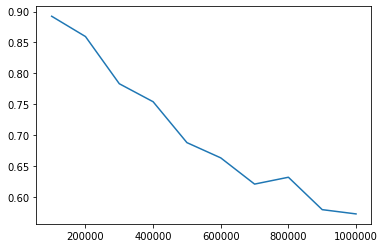

In [95]:
x, y = zip(*fraction_by_window.items())
plt.plot(x, y)

In [96]:
sparsity_by_window

{100000: 0.582,
 200000: 0.395,
 300000: 0.285,
 400000: 0.268,
 500000: 0.218,
 600000: 0.201,
 700000: 0.169,
 800000: 0.163,
 900000: 0.146,
 1000000: 0.12}

## Report the number of 100 kilobase windows, which have high sparsity of SNPs

## Average consistency of assignment per window

## Plot phase assignment in a couple of windows for intuition

/d0/home/adamk/pysccnv/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


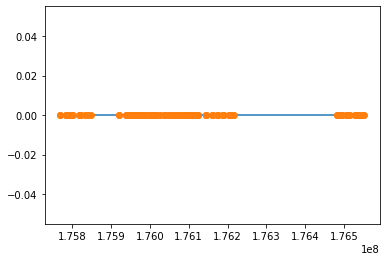

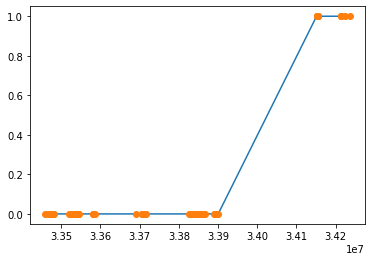

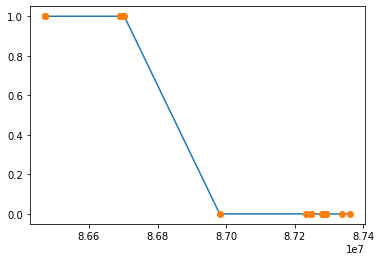

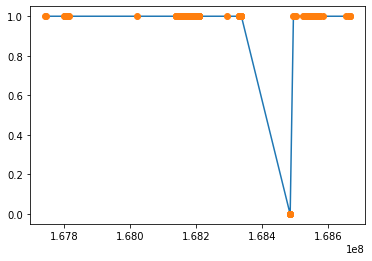

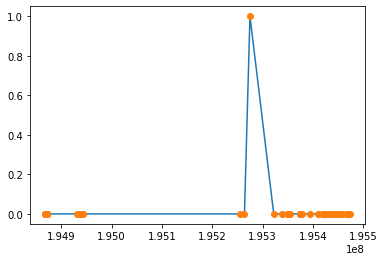

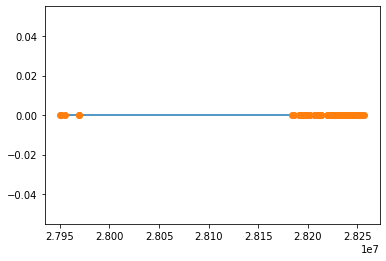

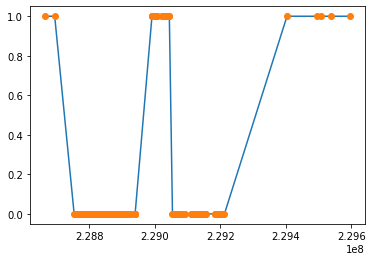

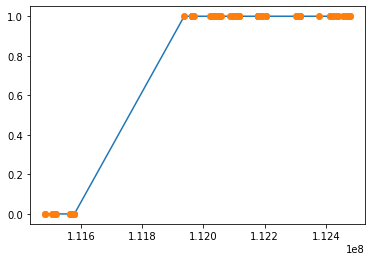

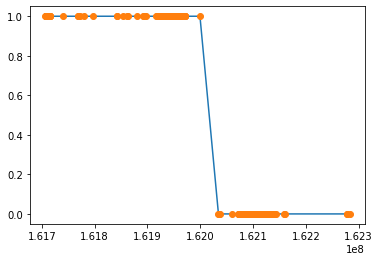

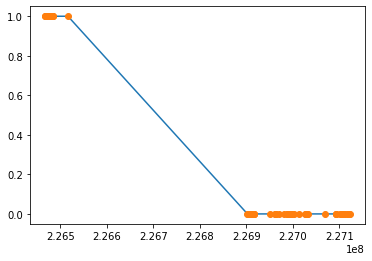

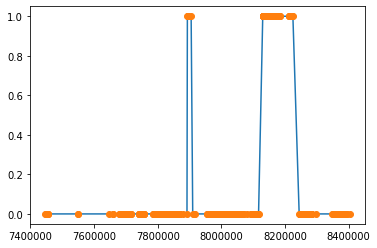

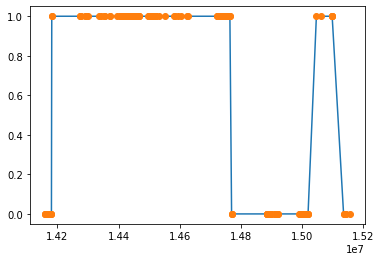

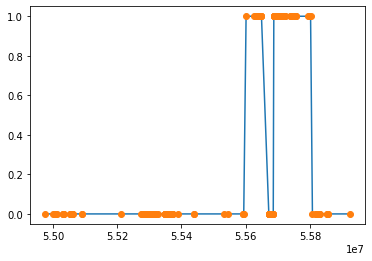

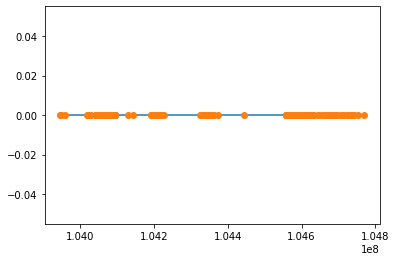

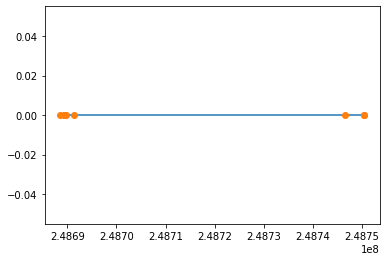

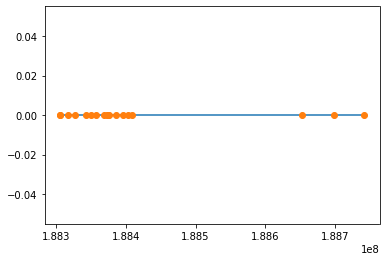

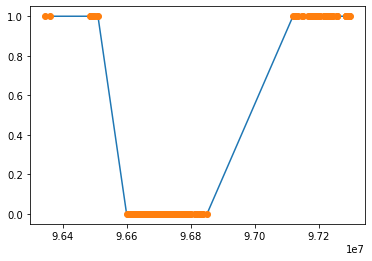

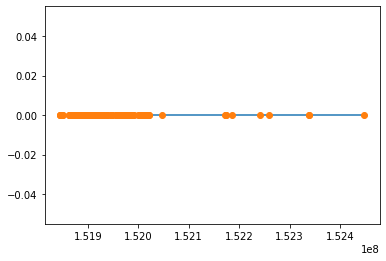

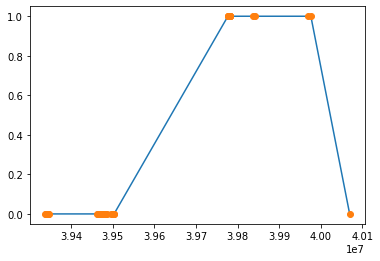

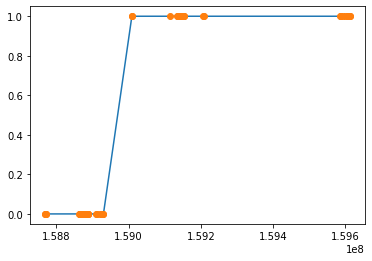

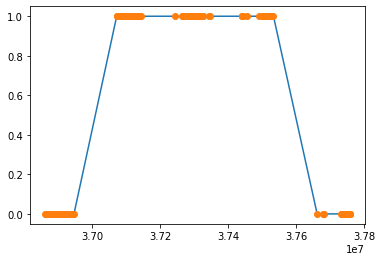

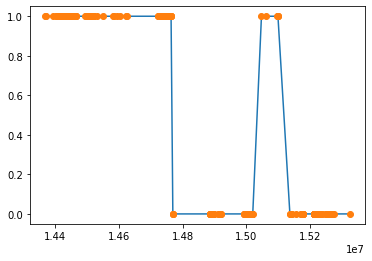

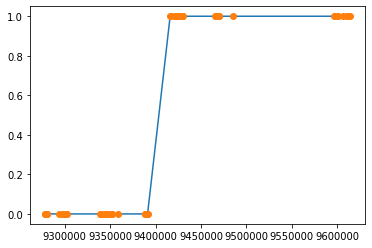

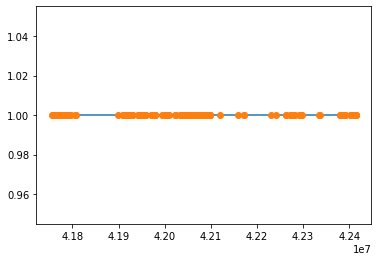

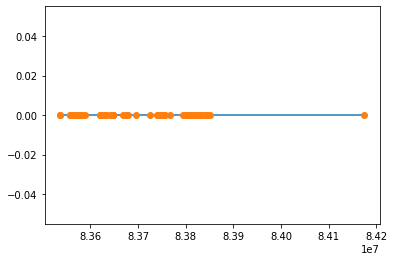

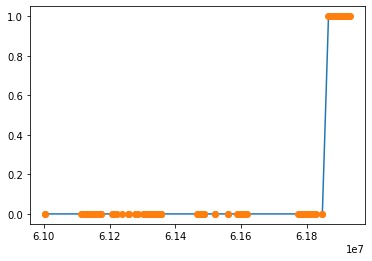

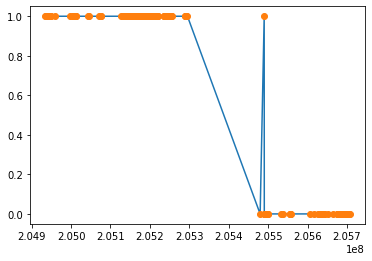

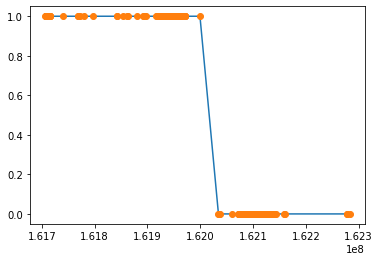

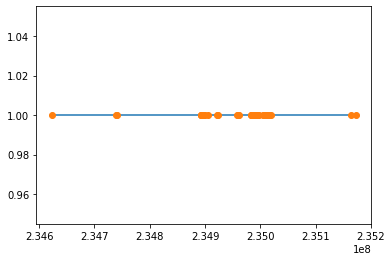

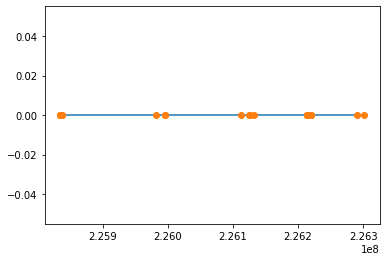

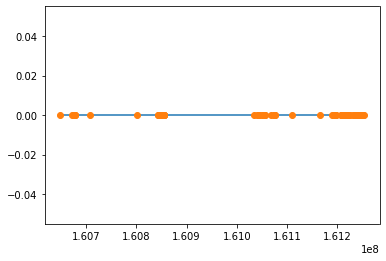

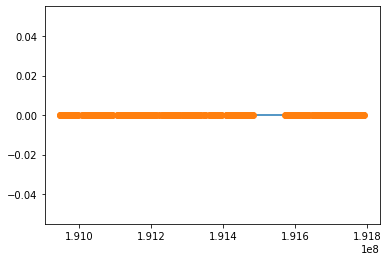

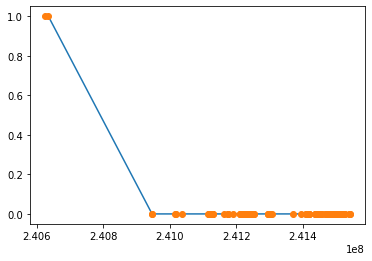

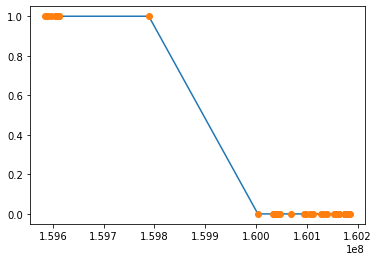

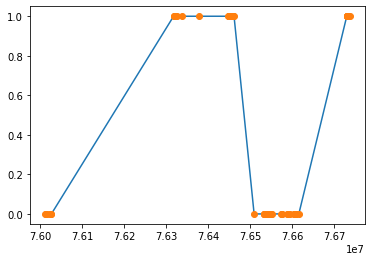

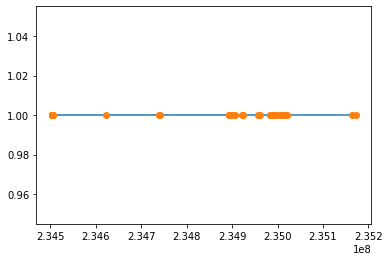

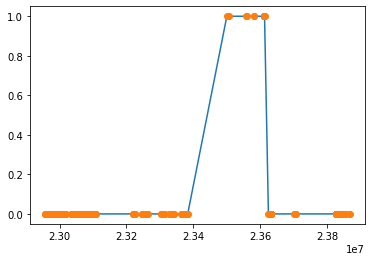

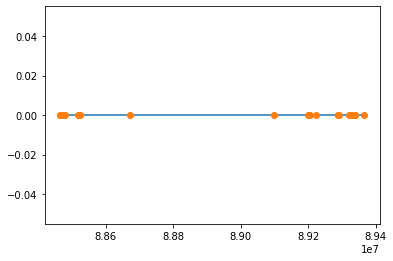

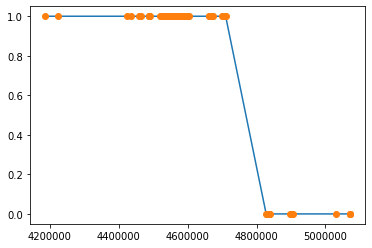

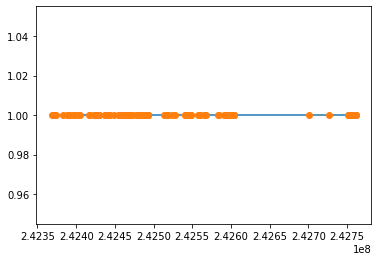

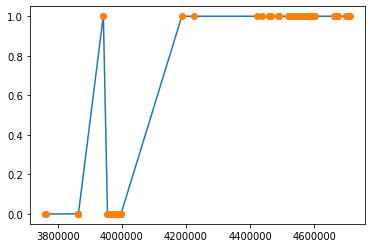

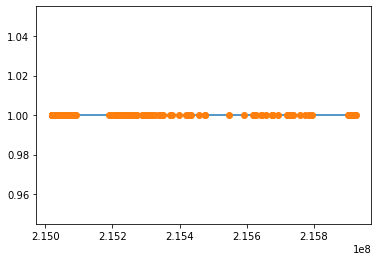

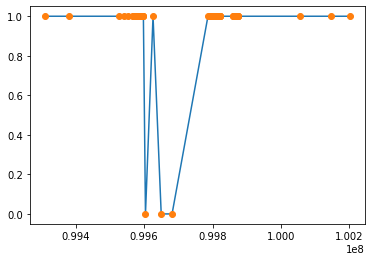

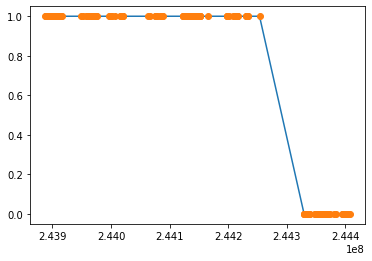

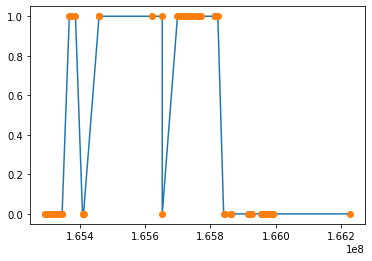

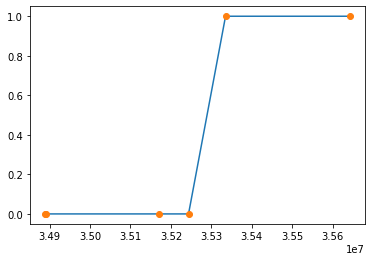

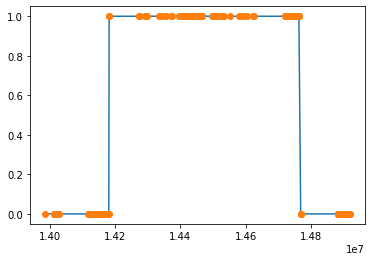

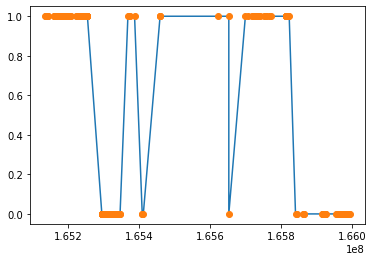

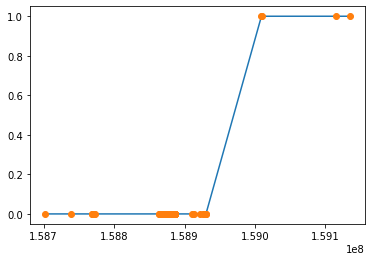

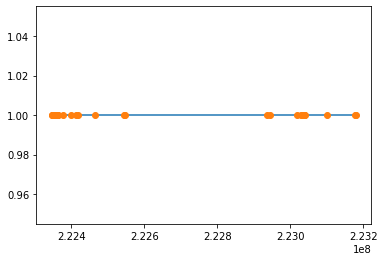

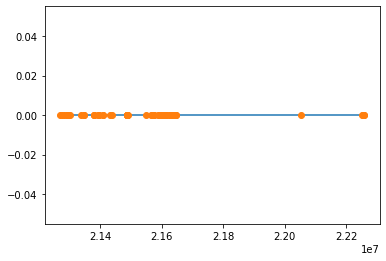

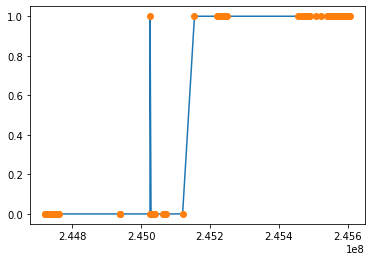

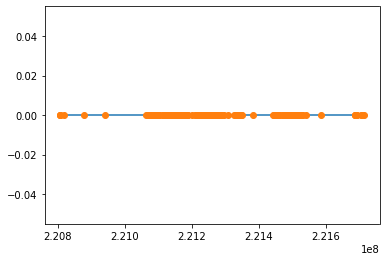

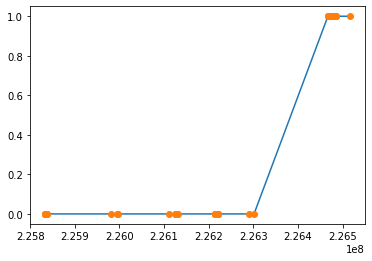

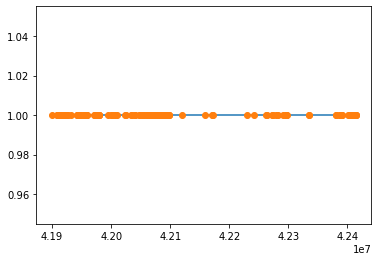

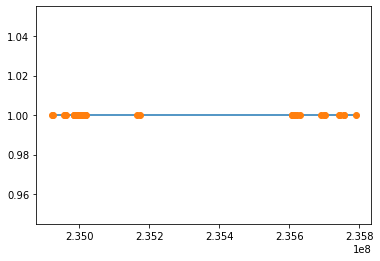

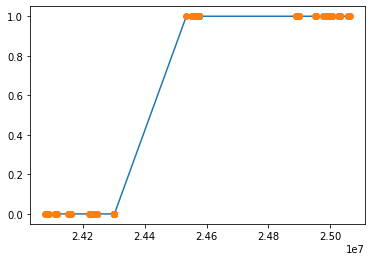

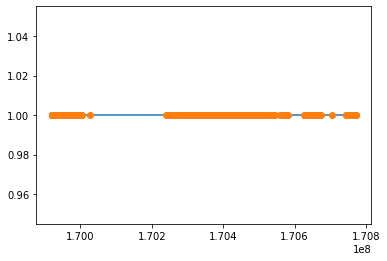

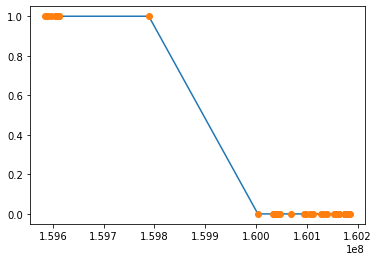

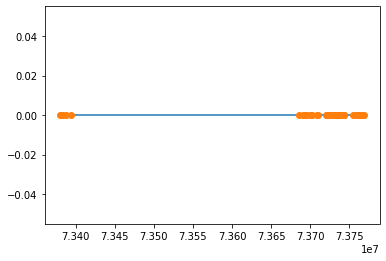

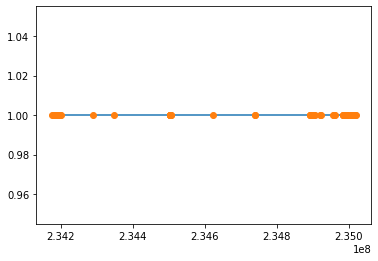

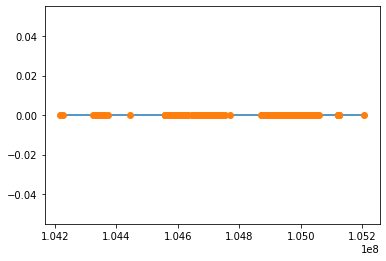

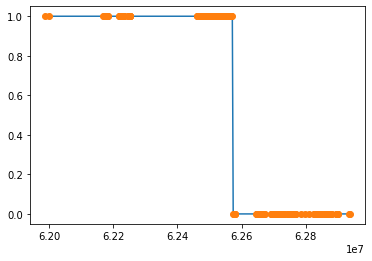

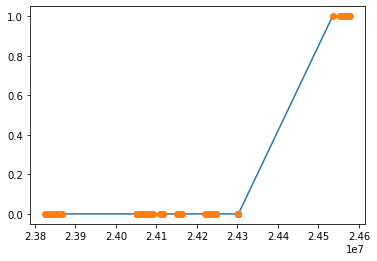

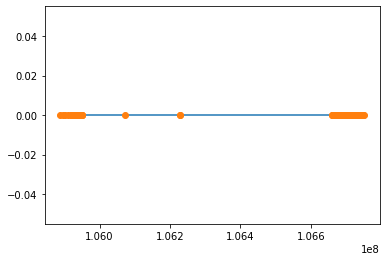

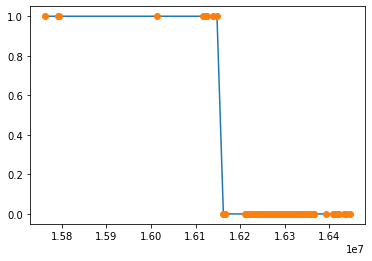

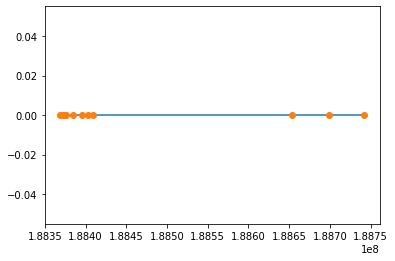

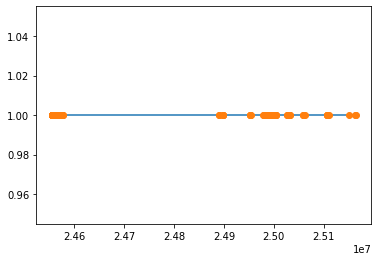

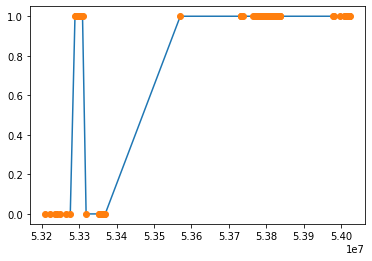

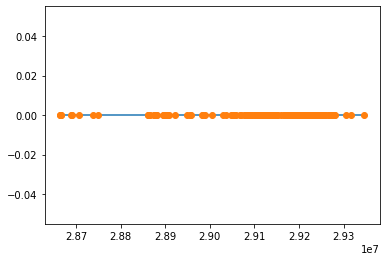

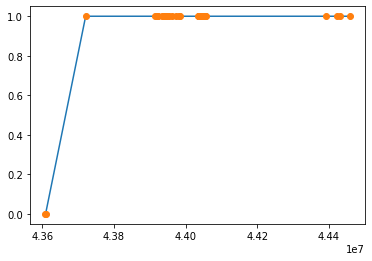

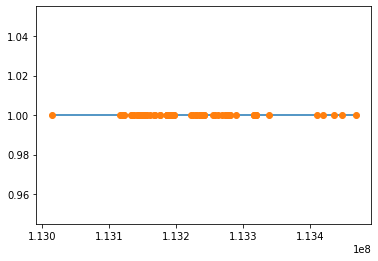

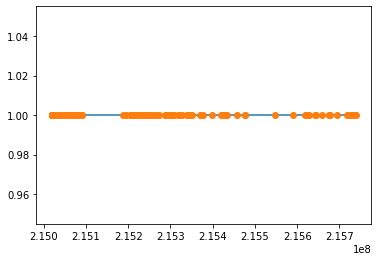

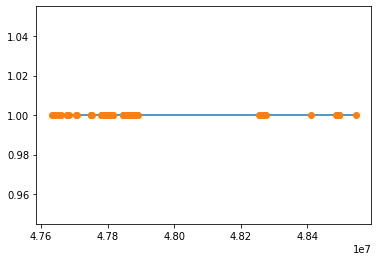

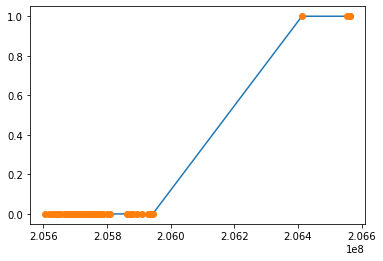

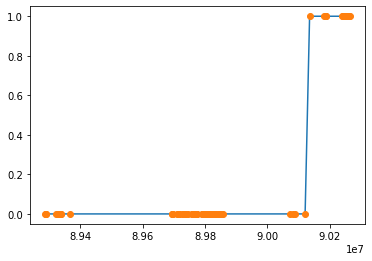

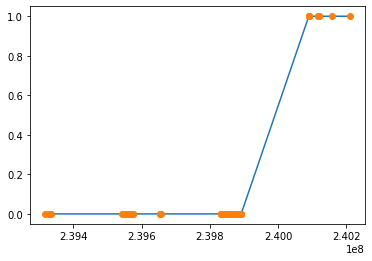

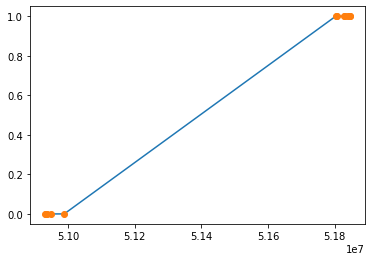

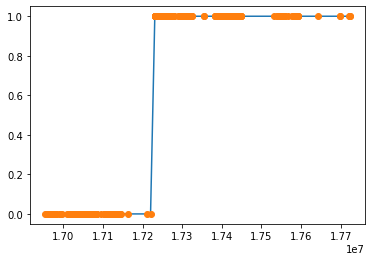

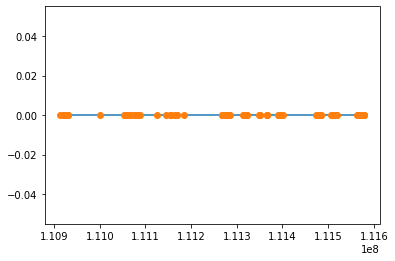

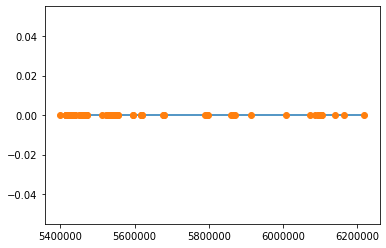

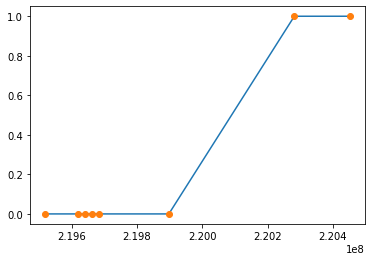

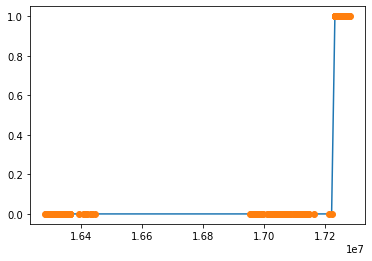

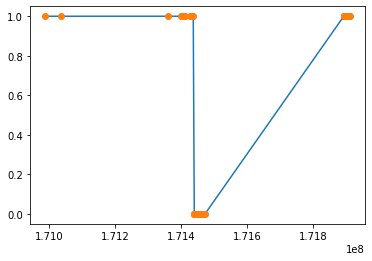

In [97]:
sparse_regions = 0

trials = 100
window = 10**6

assert min(phase_errors)[0] == max(phase_errors)[0]

chrom = min(phase_errors)[0]

lengths = []
fraction = []
for i in range(trials):
    left = random.randint(min(phase_errors)[1], max(phase_errors)[1])
    selected_window = interval(phase_errors, (chrom, left), (chrom, left + window))
    if len(selected_window) < 5:
        sparse_regions += 1
        continue
    x = [j for (i,j), k in selected_window.items()]
    y = [k for (i,j), k in selected_window.items()]
    plt.figure()
    plt.plot(x,y)
    plt.plot(x, y, "o")

# Let's check how this performance will be affected by phasing WES data

## Simulating WES data

In [ ]:
!pip install intervaltree

In [ ]:
!samtools depth -a WES_ICC/HCC1239_1_3.dedupped.realigned.recal.bam > reads.sort.coverage

In [2]:
test_coverage = """chr1    10009   1
chr1    10010   2
chr1    10011   5
chr1    10012   4
chr1    10013   5
chr1    10014   5
chr1    10015   5
chr2    10016   5
chr2    10017   5
chr2    10018   5
chr2    10019   2
chr2    10020   5"""

In [3]:
def coverage_by_chromosome(iterable, threshold):
    coverage_intervals = []
    total_coverage = {}
    last_chromosome = None
    last_streak = False
    try:
        while True:
            elem = next(iterable)
            chromosome, coord, coverage = elem.split()
            if not last_chromosome:
                last_chromosome = chromosome
            coord = int(coord)
            coverage = int(coverage)
            streak = coverage >= threshold
            if chromosome != last_chromosome:
                if streak:
                    current_interval.append(coord - 1)
                    coverage_intervals.append(current_interval)
                total_coverage[last_chromosome] = coverage_intervals
                coverage_intervals = []
                last_streak = False

            if not last_streak and streak:
                current_interval = [coord]
            if last_streak and not streak:
                current_interval.append(coord - 1)
                coverage_intervals.append(current_interval)
                current_interval = []
            last_streak = streak
            last_chromosome = chromosome
    except StopIteration:
        if streak:
            current_interval.append(coord)
            coverage_intervals.append(current_interval)
        total_coverage[last_chromosome] = coverage_intervals
    return total_coverage

In [4]:
iterable = (i for i in test_coverage.split("\n"))
threshold = 5
result = coverage_by_chromosome(iterable, threshold)
assert result == {'chr1': [[10011, 10011], [10013, 10015]], 'chr2': [[10016, 10018], [10020, 10020]]}

In [5]:
def make_intervaltrees(chromomsome_intervals):
    intervaltrees = {}
    for c, intervals in chromomsome_intervals.items():
        it = intervaltrees.setdefault(c, IntervalTree())
        for interval in intervals:
            it[interval[0]: interval[1] + 1] = None
    return intervaltrees

In [6]:
test_coverage2 = """chr1    110703   5
chr1    110704   2
chr1    110705   5
chr1    110706   4
chr1    110707   5
chr1    110708   5
chr1    110709   5
chr1    110710   5
chr1    110711   5
chr1    110712   5
chr1    110713   2
chr1    110714   5"""

In [7]:
test_intervaltrees2 = make_intervaltrees(coverage_by_chromosome((i for i in test_coverage2.split("\n")), 5))

In [8]:
test_intervaltrees2

{'chr1': IntervalTree([Interval(110703, 110704), Interval(110705, 110706), Interval(110707, 110713), Interval(110714, 110715)])}

In [ ]:
with open("reads.sort.coverage") as f:
    coverage_intervals = coverage_by_chromosome(f, 20)

In [ ]:
coverage_intervals = make_intervaltrees(coverage_intervals)

In [ ]:
def filter_vcf(filename, coverage_intervals, limit=-1, chrom_limit="", phased=False, min_qual=50):
    write_to = ".".join(filename.split(".")[:-1]) + ".filtered.vcf"
    reader = vcf.Reader(filename=filename)
    with open(write_to, "w") as f:
        writer = vcf.Writer(f, reader)
        for i, record in enumerate(reader):
            #print(record.samples[0])
            #print(record.CHROM, record.POS)
            if record.CHROM == chrom_limit:
                break
            if i == limit:
                break
            if record.samples[0].data.GQ < min_qual:
                continue
            if coverage_intervals[record.CHROM][record.POS]:
                writer.write_record(record)

In [ ]:
filter_vcf("reverse_jewish_son.vcf.gz", coverage_intervals)

Simulated WES VCF file is written as `reverse_jewish_son.vcf.filtered.vcf`. 

# Running Eagle on simulated WES data.

In [10]:
!bgzip reverse_jewish_son.vcf.filtered.vcf

In [12]:
!tabix reverse_jewish_son.vcf.filtered.vcf.gz

In [13]:
!Eagle_v2.4.1/eagle --numThreads 15 --vcfTarget reverse_jewish_son.vcf.filtered.vcf.gz --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz --outPrefix son_jewish_simulated_WES_phased

                      +-----------------------------+
                      |                             |
                      |   Eagle v2.4.1              |
                      |   November 18, 2018         |
                      |   Po-Ru Loh                 |
                      |                             |
                      +-----------------------------+

Copyright (C) 2015-2018 Harvard University.
Distributed under the GNU GPLv3+ open source license.

Command line options:

Eagle_v2.4.1/eagle \
    --numThreads 15 \
    --vcfTarget reverse_jewish_son.vcf.filtered.vcf.gz \
    --vcfRef ALL.chr1.shapeit2_integrated_v1a.GRCh38.20181129.phased.vcf.gz \
    --geneticMapFile=Eagle_v2.4.1/tables/genetic_map_hg38_withX.txt.gz \
    --outPrefix son_jewish_simulated_WES_phased 

Setting number of threads to 15
[E::bcf_hdr_parse_line] Could not parse the header line: "##CL=<vcffilter -i filtered-phase-transfer.vcf.gz -o - --javascript "ensureFormatHeader(\"##FORMAT=<ID=PS,Nu

In [109]:
phased_vcf_WES = load_vcf("son_jewish_simulated_WES_phased.vcf.gz")

In [110]:
# make sure they're het SNPs
assert not any([son[i][0] == son[i][1] for i in correctly_phased_SNPs])

In [111]:
positions = sorted(list(set(phased_vcf_WES).intersection(set(son)).intersection(correctly_phased_SNPs)))

In [112]:
def compute_phase_errors(phased_vcf, gold_standard_vcf):
    phase_errors = sortedcontainers.SortedDict()
    for position in positions:
        correct = gold_standard_vcf[position]
        phase_errors[position] = phased_vcf[position] == correct
    return phase_errors

In [113]:
phase_errors_WES = compute_phase_errors(phased_vcf_WES, son)

In [114]:
def interval(sorted_dict, minimum, maximum):
    return {i:phase_errors[i] for i in sorted_dict.irange(minimum, maximum)}

## Make sure it's just one chromosome we're working with

Otherwise the function won't work...

In [115]:
assert min(phase_errors_WES)[0] == max(phase_errors_WES)[0]

In [116]:
chrom = min(phase_errors_WES)[0]
trials = 10000
window = 10**5

def compute_consistency(phase_errors, trials, window, chrom):

    fraction_by_window = {}
    sparsity_by_window = {}

    for window in [10**5 * i for i in range(1, 11)]:
        sparse_regions = 0
        lengths = []
        fraction = []
        for _ in range(trials):
            left = random.randint(min(phase_errors)[1], max(phase_errors)[1])
            selected_window = interval(phase_errors, (chrom, left), (chrom, left + window))
            if len(selected_window) < 5:
                sparse_regions += 1
                continue
            max_key = max(selected_window)
            min_key = min(selected_window)
            consistent = selected_window[max_key] == selected_window[min_key]
            distance = max_key[1] - min_key[1]
            lengths.append(distance)
            fraction.append(consistent)
        avg_fraction = sum(fraction)/len(fraction)
        fraction_by_window[window] = avg_fraction
        sparsity_by_window[window] = sparse_regions/trials 
    return fraction_by_window, sparsity_by_window

In [117]:
fraction_consistent, sparsity = compute_consistency(phase_errors_WES, trials, window, chrom)

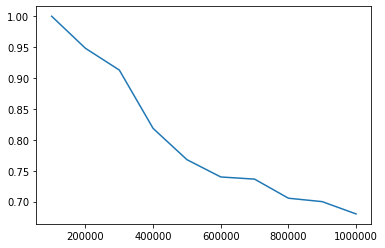

In [118]:
x, y = zip(*fraction_consistent.items())
plt.plot(x, y)

In [121]:
def make_plots(phase_errors, no_plots, window):
    plots = 0
    sparse_regions = 0
    trials = 1000 * no_plots
    for i in range(trials):
        left = random.randint(min(phase_errors)[1], max(phase_errors)[1])
        selected_window = interval(phase_errors, (chrom, left), (chrom, left + window))
        if len(selected_window) < 5:
            sparse_regions += 1
            continue
        if plots >= no_plots:
            break
        x = [j for (i,j), k in selected_window.items()]
        y = [k for (i,j), k in selected_window.items()]
        plt.figure()
        plt.plot(x, y)
        plt.plot(x, y, "o")
        plots += 1
    return sparse_regions, plots

(0, 20)

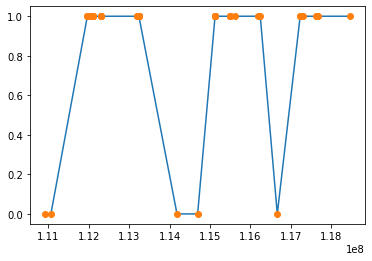

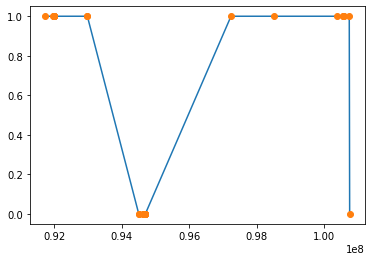

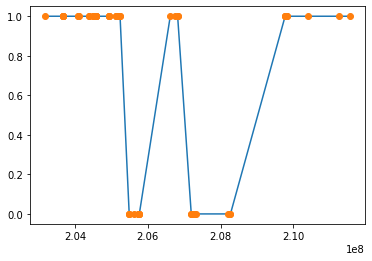

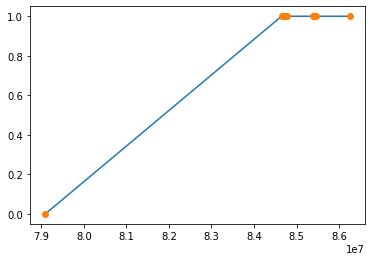

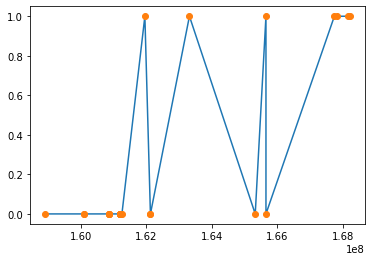

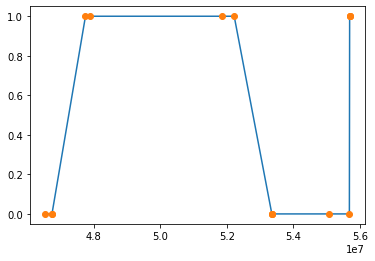

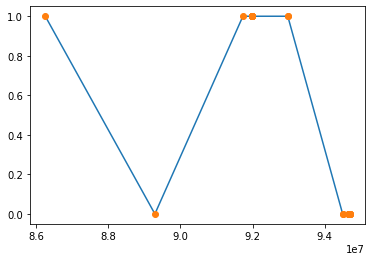

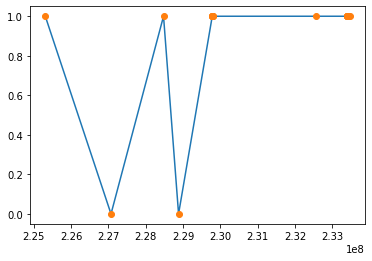

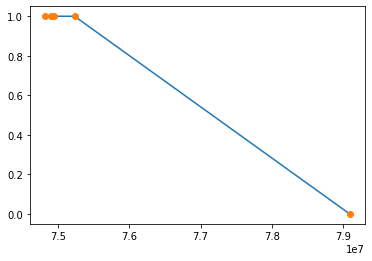

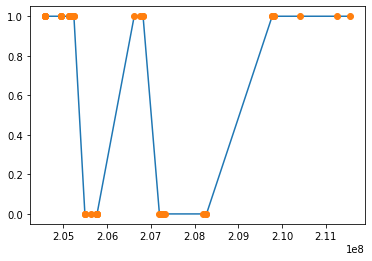

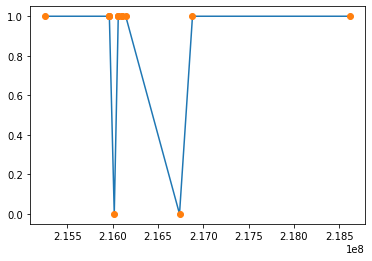

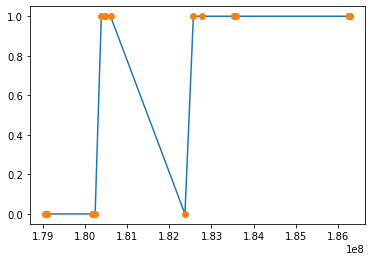

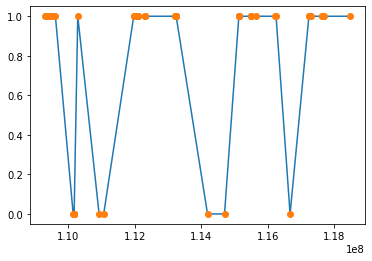

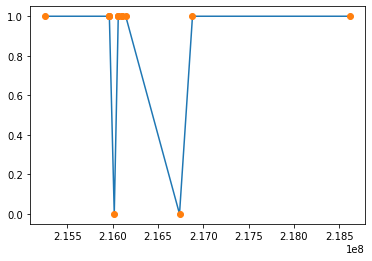

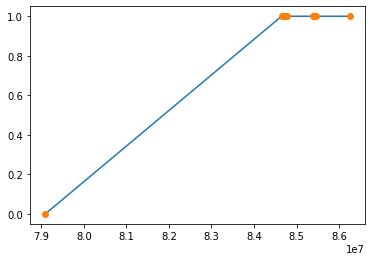

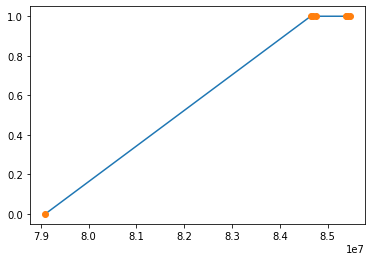

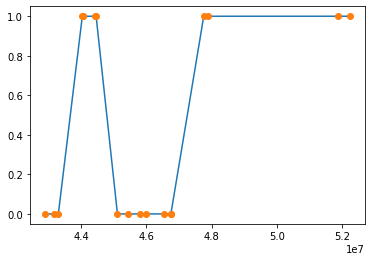

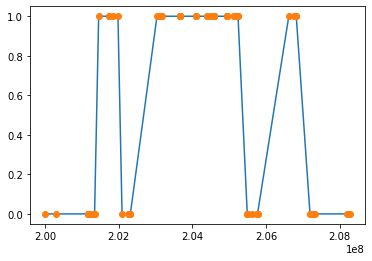

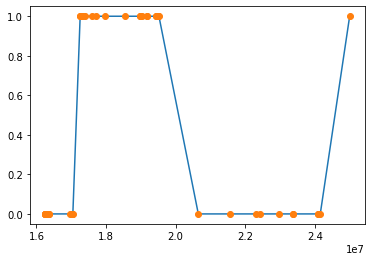

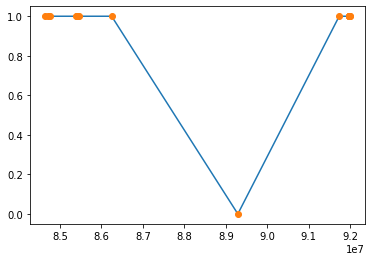

In [122]:
make_plots(phase_errors_WES, 20, 10**7)